In [1]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean, linregress
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, MultipleLocator
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# Import dataframes
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\Regime_check\allorder_TTVFast_fits.csv")
fits.head()

,e1,w1,e2,w2,Delta,mmr,j,N,P1,P2,...,res1,A2,B2,V2,Pttv2,phase2,std2,res2,R2_1,R2_2
0,0.001410,214.983207,0.001410,34.983207,0.092250,3:2,3,1,30,49.151241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.089057,319.762149,0.089057,319.762149,-0.017099,7:5,7,2,30,41.281823,...,0.000525,-6.656430e-05,1.899893e-07,0.000589,333.690662,0.592429,0.000791,0.000672,0.273060,0.278562
2,0.026567,33.578327,0.026567,213.578327,-0.015354,4:3,4,1,30,39.385850,...,0.001932,3.852556e-04,-2.010537e-07,0.008393,652.399372,4.865618,0.006332,0.002289,0.870769,0.869298
3,0.036570,53.952120,0.036570,233.952120,0.076126,3:1,3,2,30,96.851375,...,0.000013,-1.178645e-07,-4.106038e-10,0.000059,424.310264,2.665432,0.000041,0.000001,0.712373,0.999249
4,0.004234,32.758994,0.004234,32.758994,0.025265,4:3,4,1,30,41.010602,...,0.000504,7.729594e-05,-1.330196e-07,0.000925,401.978009,3.858321,0.000902,0.000629,0.448899,0.514417


In [3]:
# Compare error relative to solution similar to figure 2 of Deck-Agol
# Code of course copypasted from 1st order TTVfast validation
valid = fits['valid']
j = fits['j']; N = fits['N']
mmr = fits['mmr']
mu_in = fits['mu1']; mu_out = fits['mu2']
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = np.abs(fits['Pttv1']); PTTV_out = np.abs(fits['Pttv2'])
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]
Mstar = 1

# Extract mu_in and mu_out
mu_calc_in, mu_calc_out = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mu_calc_in = np.append(mu_calc_in, np.nan)
        mu_calc_out = np.append(mu_calc_out, np.nan)
        continue

    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_code_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i], inner_period=P_in[i])
    mu_code_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i], outer_period=P_out[i])

    mu_calc_in = np.append(mu_calc_in, mu_code_in)
    mu_calc_out = np.append(mu_calc_out, mu_code_out)

compare = fits.copy()
compare['mu_calc_in'] = mu_calc_in
compare['mu_calc_out'] = mu_calc_out
compare.head()

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:46<00:00, 601.78it/s]


,e1,w1,e2,w2,Delta,mmr,j,N,P1,P2,...,B2,V2,Pttv2,phase2,std2,res2,R2_1,R2_2,mu_calc_in,mu_calc_out
0,0.001410,214.983207,0.001410,34.983207,0.092250,3:2,3,1,30,49.151241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.089057,319.762149,0.089057,319.762149,-0.017099,7:5,7,2,30,41.281823,...,1.899893e-07,0.000589,333.690662,0.592429,0.000791,0.000672,0.273060,0.278562,NaN,NaN
2,0.026567,33.578327,0.026567,213.578327,-0.015354,4:3,4,1,30,39.385850,...,-2.010537e-07,0.008393,652.399372,4.865618,0.006332,0.002289,0.870769,0.869298,0.000003,0.000003
3,0.036570,53.952120,0.036570,233.952120,0.076126,3:1,3,2,30,96.851375,...,-4.106038e-10,0.000059,424.310264,2.665432,0.000041,0.000001,0.712373,0.999249,0.000003,0.000003
4,0.004234,32.758994,0.004234,32.758994,0.025265,4:3,4,1,30,41.010602,...,-1.330196e-07,0.000925,401.978009,3.858321,0.000902,0.000629,0.448899,0.514417,0.000002,0.000003


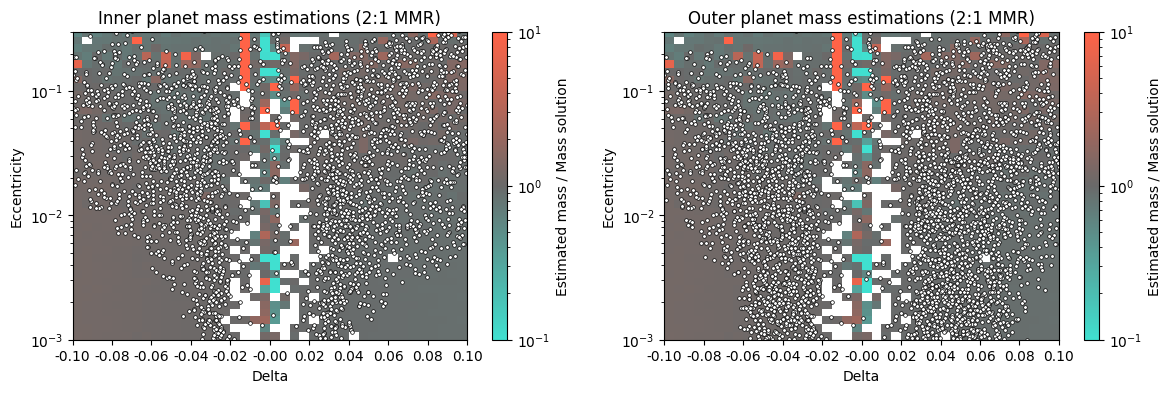

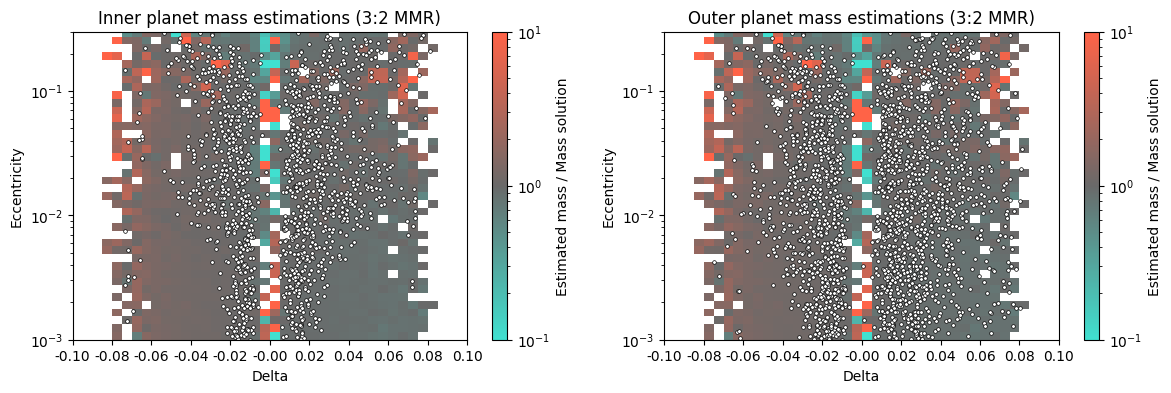

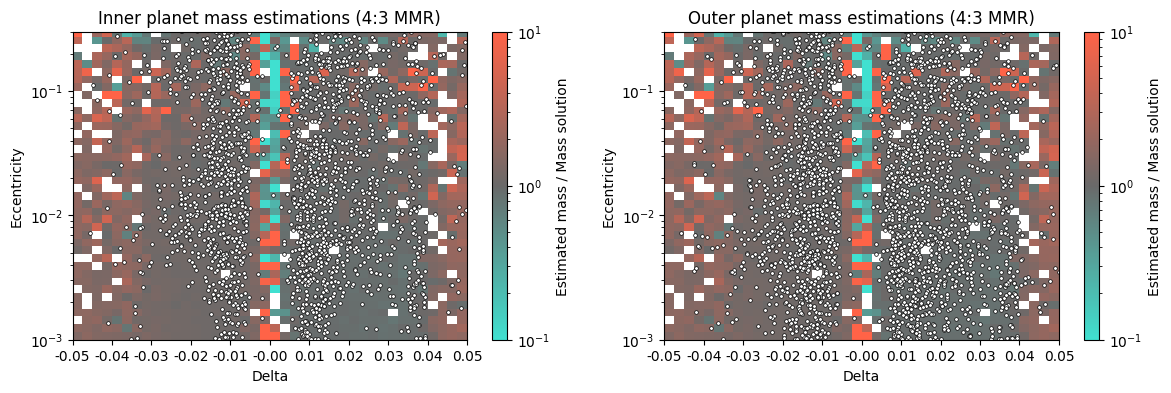

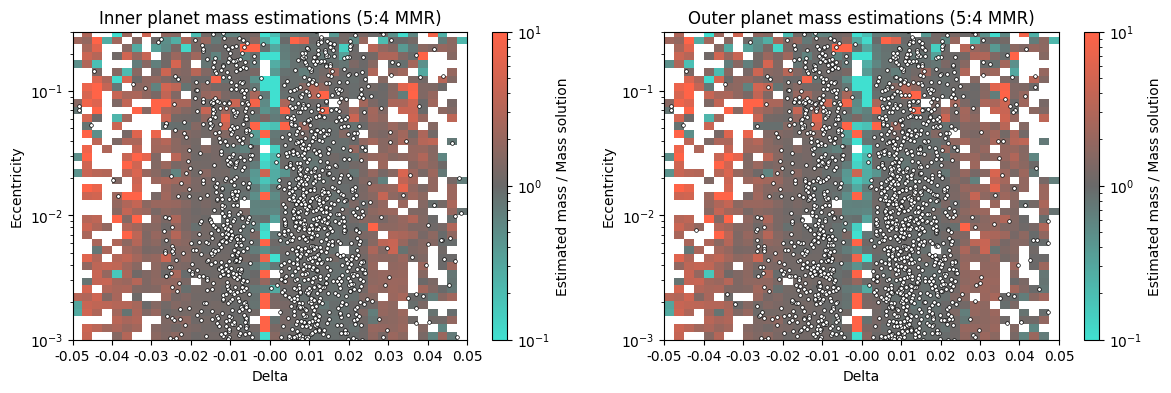

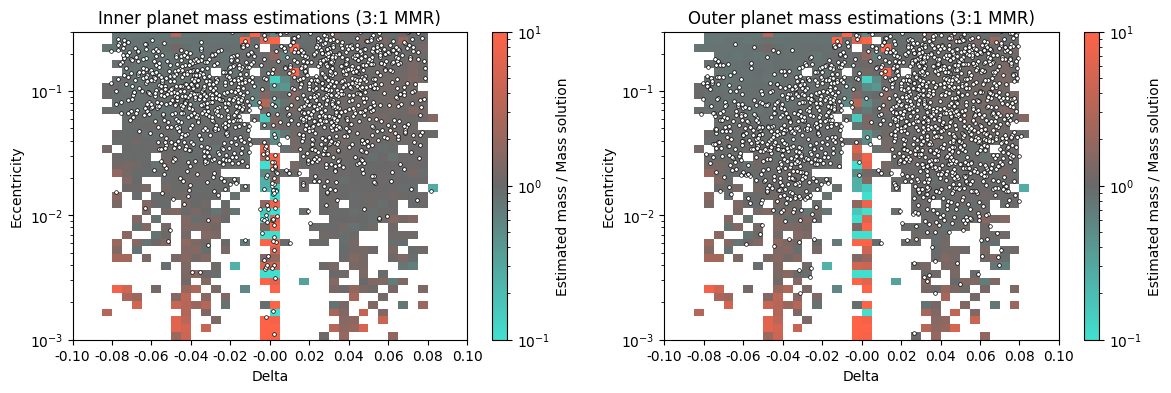

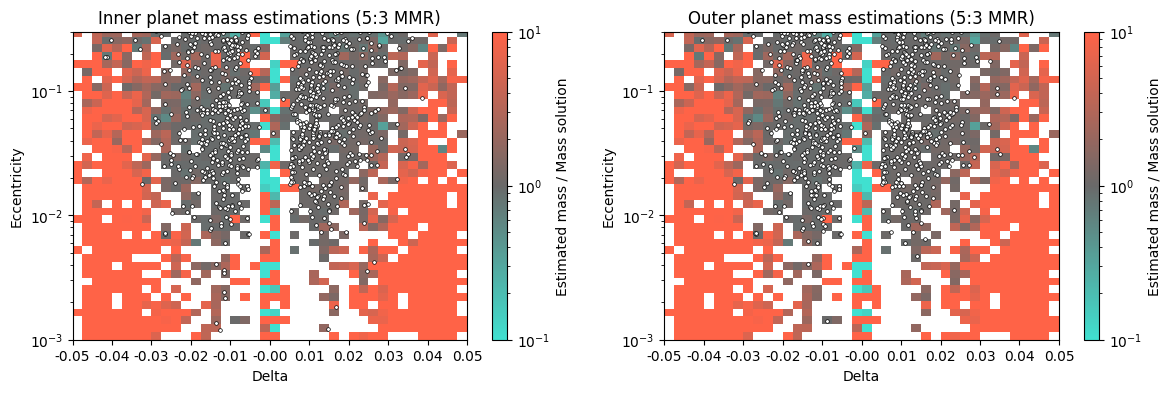

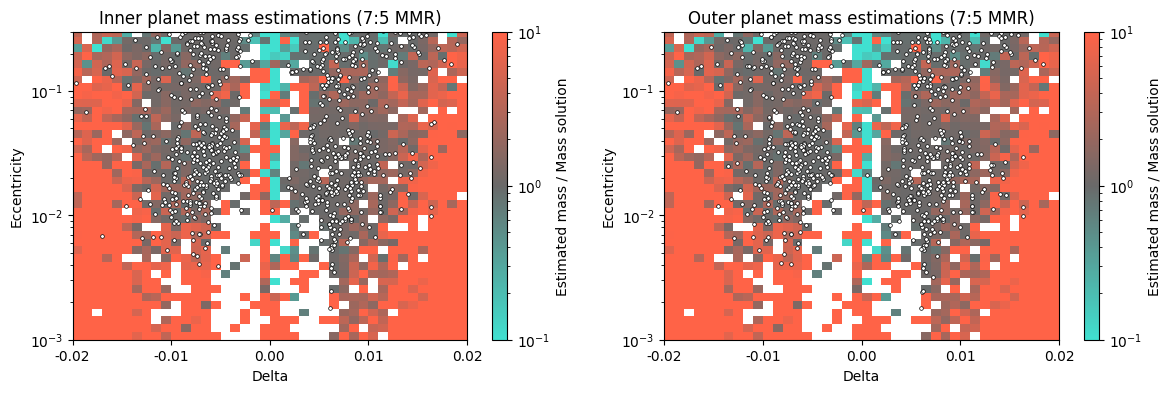

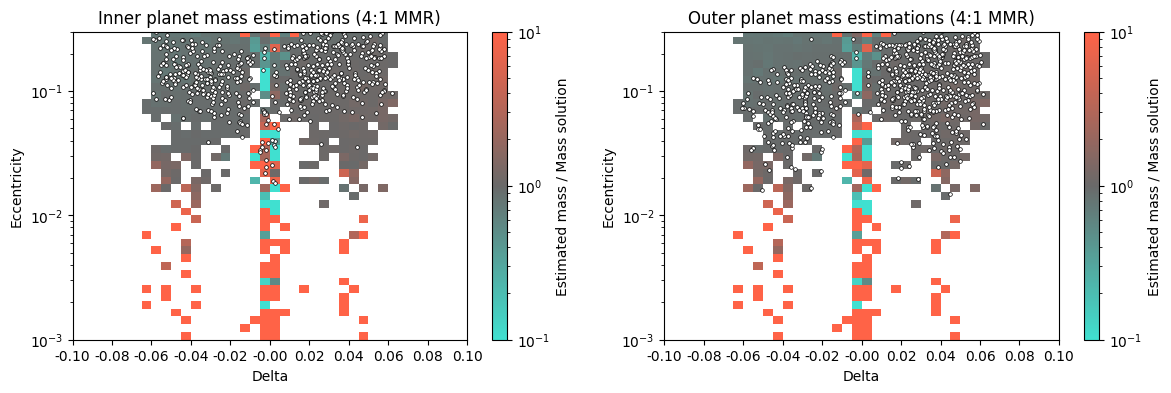

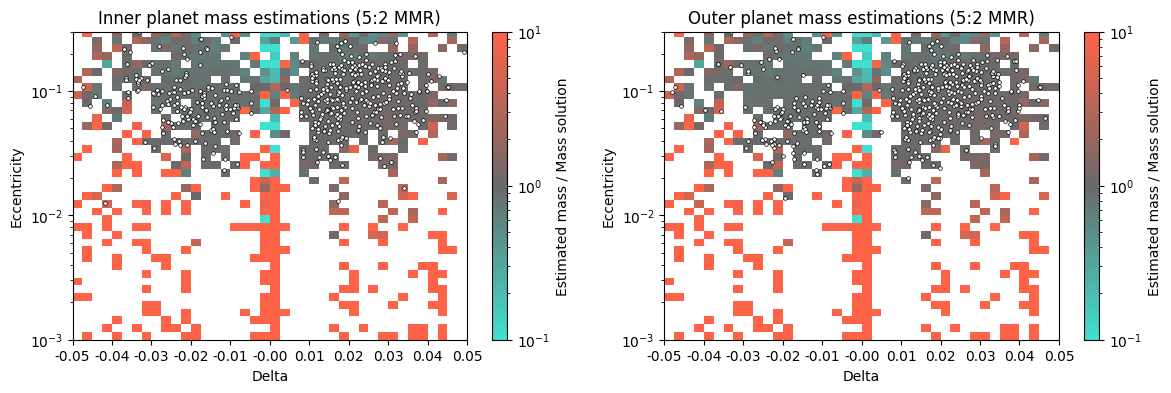

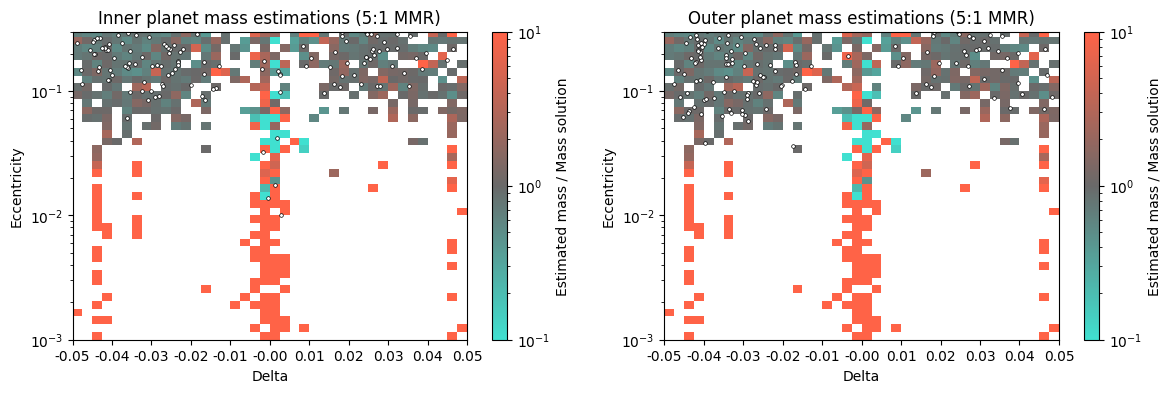

In [12]:
# MMR to max delta mapping
mmr_list = ['2:1', '3:2', '4:3', '5:4', '3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
Delta_maxes = [0.1, 0.1, 0.05, 0.05,
               0.1, 0.05, 0.02, 0.1, 0.05, 0.05]
mmr_to_delta = dict(zip(mmr_list, Delta_maxes))

# Recreate figure 2
def PlotValidity(mmr):
    compare_at_mmr = compare[(compare.mmr == mmr) & (compare.valid == True)]

    # Extract values from df
    Delta = compare_at_mmr['Delta']
    e1 = compare_at_mmr['e1']; e2 = compare_at_mmr['e2']
    err1 = compare_at_mmr['mu_calc_in'] / compare_at_mmr['mu1']
    err2 = compare_at_mmr['mu_calc_out'] / compare_at_mmr['mu2']

    # 10% Error tolerance
    errtol = 1.1
    err1_10p = (err1 <= errtol) & (err1 >= 1/errtol)
    err2_10p = (err2 <= errtol) & (err2 >= 1/errtol)

    # Max-delta extraction from mapping
    Delta_max = mmr_to_delta[mmr]
    if Delta_max <= 0.05:
        locator_interval = 0.01
    else:
        locator_interval = 0.02
    
    # Set up grid image
    xbins = np.linspace(-Delta_max, Delta_max, 41)
    ybins = 10**np.linspace(-3, -0.5, 41)
    # Digitize points into bins (i.e. map Delta = 0 to bin 50/100)
    xi = np.digitize(Delta, xbins) - 1
    yi = np.digitize(e1, ybins) - 1
    Z1 = Z2 = np.full((len(ybins)-1, len(xbins)-1), np.nan) # Initialize array for medians
    
    # Compute median in each bin
    for i in range(len(xbins)-1):
        for j in range(len(ybins)-1):
            mask = (xi == i) & (yi == j)
            err1values = err1[mask]
            err2values = err2[mask]
            Z1[j,i] = np.nanmedian(err1[mask]) if np.any(~np.isnan(err1values)) else np.nan
            Z2[j,i] = np.nanmedian(err2[mask]) if np.any(~np.isnan(err2values)) else np.nan
    
    # Plot
    fig, ax =  plt.subplots(1, 2, figsize=(14,4))
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['turquoise', 'dimgray', 'tomato'])
    norm = mcolors.LogNorm(1e-1, 1e+1)
    
    im0 = ax[0].pcolormesh(xbins, ybins, Z1, norm=norm, cmap=cmap, shading='auto')
    sc0 = ax[0].scatter(Delta[err1_10p], e1[err1_10p], s=7, facecolor='white', edgecolor='black', linewidth=0.5, marker='o')
    plt.colorbar(im0, ax=ax[0], label='Estimated mass / Mass solution')
    ax[0].set_title(f'Inner planet mass estimations ({mmr} MMR)')
    
    im1 = ax[1].pcolormesh(xbins, ybins, Z2, norm=norm, cmap=cmap, shading='auto')
    sc1 = ax[1].scatter(Delta[err2_10p], e1[err2_10p], s=7, facecolor='white', edgecolor='black', linewidth=0.5, marker='o')
    plt.colorbar(im1, ax=ax[1], label='Estimated mass / Mass solution')
    ax[1].set_title(f'Outer planet mass estimations ({mmr} MMR)')
    
    for i, a in enumerate(ax):
        a.set_yscale('log')
        a.set_xlabel('Delta'); a.set_ylabel('Eccentricity')
        a.set_xlim(-Delta_max, Delta_max); a.set_ylim(1e-3, 3e-1)
        a.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        a.xaxis.set_major_locator(MultipleLocator(locator_interval))
    
    plt.show()

for mmr in mmr_list:
    PlotValidity(mmr)

In [5]:
# Export results
compare.to_csv("allorder_TTVFast_outputs.csv", index=False)